In [1]:
import os, sys, datetime, time, json, numpy as np, matplotlib.pyplot as plt
from tqdm.auto import tqdm

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
print(f"Current path: {os.getcwd()}")
sys.path.append('./')

from environments import NoiseEnv
from bandit_agents import IGPUCB

Current path: /Users/marcomussi/git/HetGaussianProcesses


In [2]:
# CONFIG PANEL

n_actions_lst = [5, 10, 15, 20]
horizon = 3000
kernel_L = 1000
num_trials = 3
sigma_sq = 0.25 # Bernoulli
draw_every = 100
action_dim = 1 # only 1 available in this notebook
delta = 1 / horizon
B = 1

HET = "\\hetgp"
HOM = "\\homgp"
HOM_EFF = "\\homeffgp"
algs_to_test = [HET ,HOM, HOM_EFF]

def exp_reward_values(actions):
    assert (actions >=0).all() and (actions <=1).all(), "error in action vals"
    trasf = actions * 6.28 - 1
    return 0.5 * np.cos(trasf) + 0.5

In [3]:
dateformat = "(%Y-%b-%d %Ih%Mm%p)"
if horizon % draw_every != 0:
    raise ValueError("reminder of horizon/draw_every not zero")
n_timesamples = int(horizon / draw_every)
horizons_plt = np.linspace(0, horizon-1, int(horizon / draw_every), dtype=int)

elapsed_time_dict = {}

for n_actions in n_actions_lst:

    print(f"{n_actions} Actions")

    elapsed_time_dict[n_actions] = {}

    actions = np.linspace(0, 1, n_actions)

    values = exp_reward_values(actions)

    actions = actions.reshape(n_actions, action_dim)

    plt.figure()

    for alg_i, alg in enumerate(algs_to_test):

        print(f"\tAlg: {alg}")

        elapsed_time_dict[n_actions][alg] = np.zeros((num_trials, n_timesamples))

        for trial_i in tqdm(range(num_trials)):
            
            if alg == HET:
                agent = IGPUCB(n_actions, action_dim, actions, kernel_L, sigma_sq, 
                               B, delta, het=True)
            elif alg == HOM:
                agent = IGPUCB(n_actions, action_dim, actions, kernel_L, sigma_sq, 
                               B, delta, het=False, incr_inverse=False)
            elif alg == HOM_EFF:
                agent = IGPUCB(n_actions, action_dim, actions, kernel_L, sigma_sq, 
                               B, delta, het=False, incr_inverse=True)
            else:
                raise NotImplementedError("Not recognized algorithm.")
            
            env = NoiseEnv(actions, values, sigma_sq)
            
            start_time = time.time()
            
            for t in range(horizon):

                action = agent.pull()
                reward = env.step(action)
                agent.update(reward)

                if t % draw_every == 0:
                    elapsed_time_dict[n_actions][alg][trial_i, int(t / draw_every)] = (time.time() - start_time) # / (t + 1)

5 Actions
	Alg: \hetgp


  0%|          | 0/3 [00:00<?, ?it/s]

	Alg: \homgp


  0%|          | 0/3 [00:00<?, ?it/s]

	Alg: \homeffgp


  0%|          | 0/3 [00:00<?, ?it/s]

10 Actions
	Alg: \hetgp


  0%|          | 0/3 [00:00<?, ?it/s]

	Alg: \homgp


  0%|          | 0/3 [00:00<?, ?it/s]

	Alg: \homeffgp


  0%|          | 0/3 [00:00<?, ?it/s]

15 Actions
	Alg: \hetgp


  0%|          | 0/3 [00:00<?, ?it/s]

	Alg: \homgp


  0%|          | 0/3 [00:00<?, ?it/s]

	Alg: \homeffgp


  0%|          | 0/3 [00:00<?, ?it/s]

20 Actions
	Alg: \hetgp


  0%|          | 0/3 [00:00<?, ?it/s]

	Alg: \homgp


  0%|          | 0/3 [00:00<?, ?it/s]

	Alg: \homeffgp


  0%|          | 0/3 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

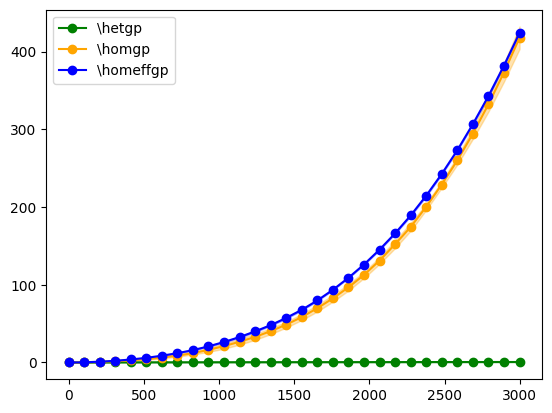

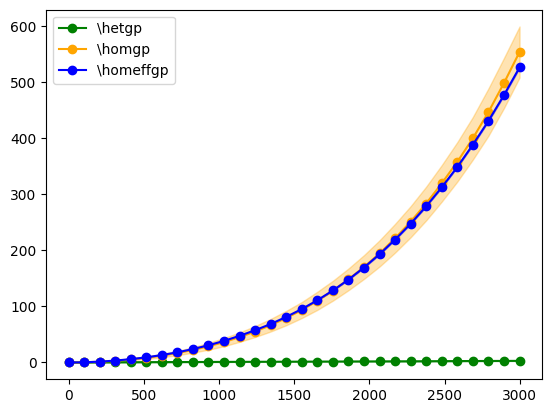

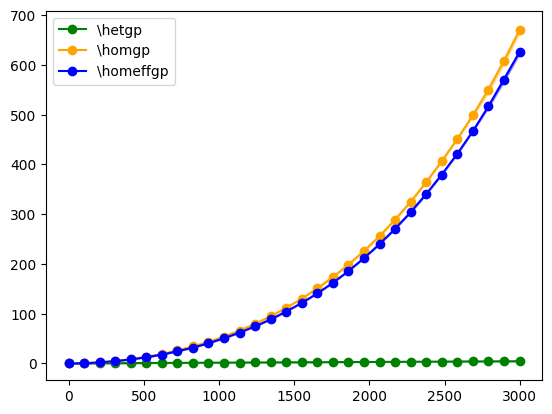

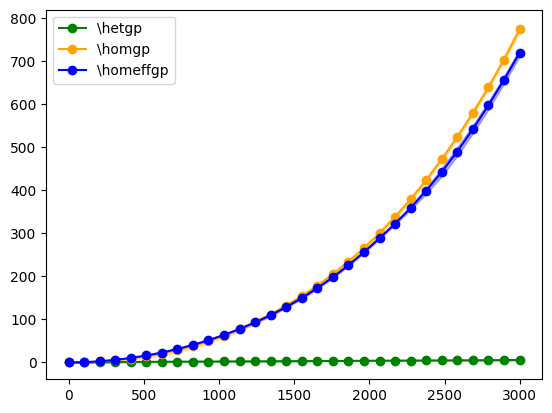

In [4]:
color_lst = ["green", "orange", "blue"]

result_folder = "results"
if not os.path.exists(result_folder):
    os.makedirs(result_folder)

for n_actions in n_actions_lst:

    plt.figure()

    for alg_i, alg in enumerate(algs_to_test):
        
        vect = elapsed_time_dict[n_actions][alg]
        vect_mean = np.mean(vect, axis=0)
        vect_ci = 1.96 * np.std(vect, axis=0) / np.sqrt(num_trials)

        plt.plot(horizons_plt, vect_mean, "-o", color=color_lst[alg_i], label=alg)
        plt.fill_between(horizons_plt, vect_mean - vect_ci, vect_mean + vect_ci, 
                         color=color_lst[alg_i], alpha=0.3)
    
    plt.legend()
    # plt.yscale("log")
    
    save_path = f"{result_folder}/actions{n_actions}_horizon{horizon}_trials{num_trials}_algs{algs_to_test}_{datetime.datetime.now().strftime(dateformat)}"

    plt.savefig(f"{save_path}.jpg")

    try:
        import tikzplotlib as tkz
        tkz.save(f"{save_path}.tex")
    except Exception as e:
        print(f"Error: {e}")
        print("failed to save in tikz")

for n_actions in n_actions_lst:
    for alg in algs_to_test:
        elapsed_time_dict[n_actions][alg] = list(elapsed_time_dict[n_actions][alg])

def make_json_serializable(obj):
    if isinstance(obj, set):
        return list(obj)
    if isinstance(obj, (float, int, str, bool)) or obj is None:
        return obj
    if isinstance(obj, dict):
        return {k: make_json_serializable(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        return [make_json_serializable(v) for v in obj]
    return str(obj)  # fallback per tipi non standard

serializable_dict = make_json_serializable(elapsed_time_dict)

save_path = f"{result_folder}/actions{n_actions_lst}_horizon{horizon}_trials{num_trials}_algs{algs_to_test}_{datetime.datetime.now().strftime(dateformat)}.json"

with open(save_path, "w", encoding="utf-8") as time_json:
    json.dump(serializable_dict, time_json, ensure_ascii=False, indent=4)